In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
from distgen.dist import SuperGaussian
from distgen.dist import Norm
from distgen.physical_constants import unit_registry

from matplotlib import pyplot as plt

import numpy as np

# Metrics for comparing different distributions
---
In some cases, it is desired to target a particular distribution shape in an optimization.  To facilitate this the following two metrics are implemented:

## Kullback-Leibler (Relative Entropy)
Defined as:
$D_{KL}(P|Q) = \int_{-\infty}^{\infty}p(x)\ln{\left(\frac{p(x)}{q(x)}\right)} dx$

Note that this is not well defined in regions where the PDF $q(x)=0$.  This causes trouble for distributions like a uniform distribution.  For this, its suggested to use a SuperGaussian to approximate the uniform dist (see below).

https://en.wikipedia.org/wiki/Kullback–Leibler_divergence

In [3]:
L = 2 * unit_registry("ps")
avg_t_sg = 0 * unit_registry("ps")
sigma_t_sg = L / np.sqrt(12)

In [4]:
sg = SuperGaussian("t", avg_t=avg_t_sg, sigma_t=sigma_t_sg, p=12)

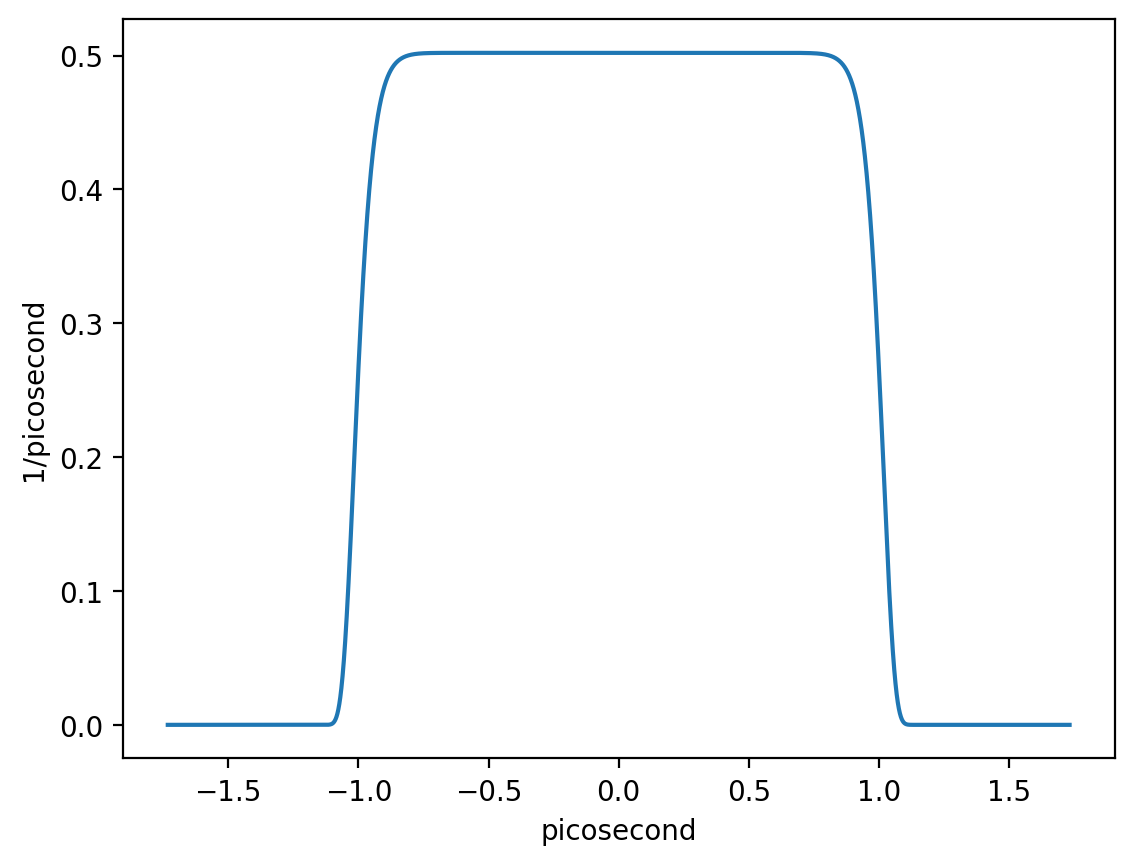

In [5]:
tsg, Psg = sg.get_x_pts(), sg.pdf()
plt.plot(tsg, Psg);

In [6]:
norm = Norm("t", avg_t=avg_t_sg, sigma_t=sigma_t_sg)

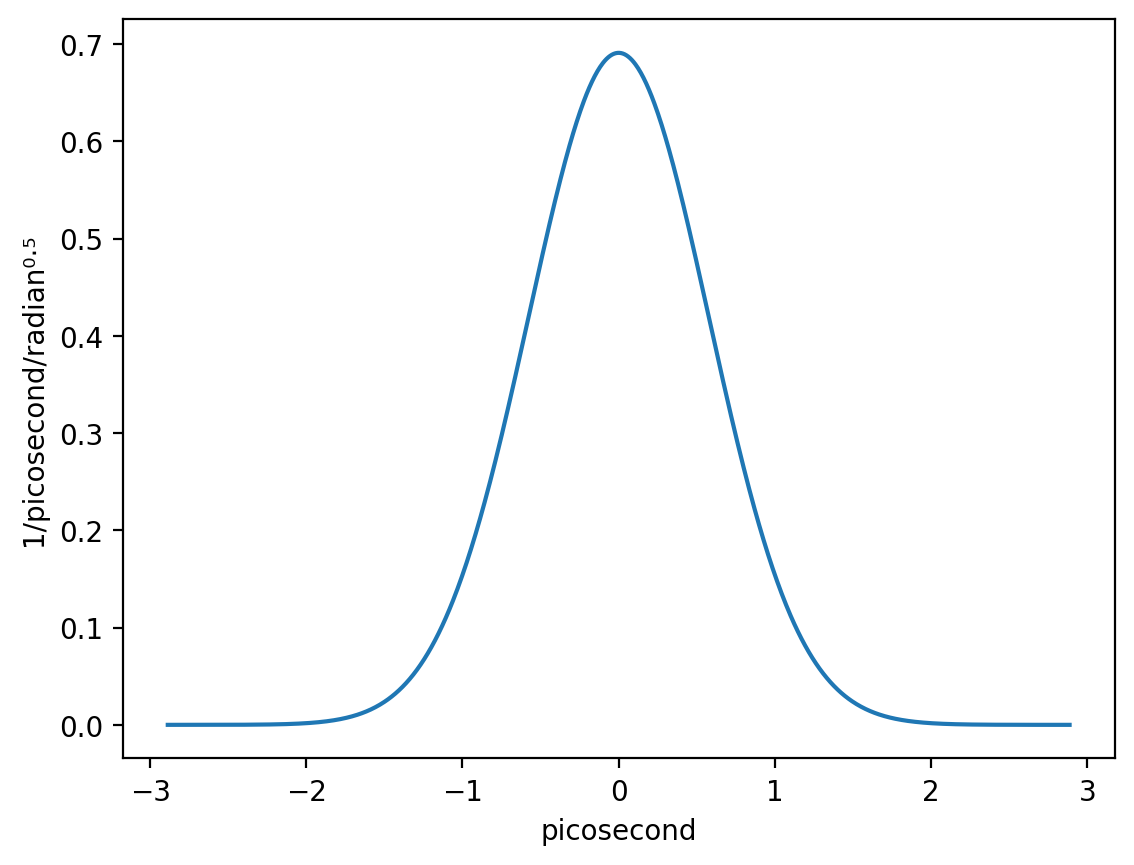

In [7]:
tn, Pn = norm.get_x_pts(), norm.pdf()
plt.plot(tn, Pn);

In [8]:
from distgen.metrics import kullback_liebler_div

In [9]:
kullback_liebler_div(tn, Pn, tsg, Psg, as_float=False)

<Quantity(4.30137011, 'dimensionless')>

The functions work with raw NumPy arrays, and support both float output or Pint Quantity outputs:

In [10]:
kullback_liebler_div(
    tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True
)

np.float64(4.301370109274345)

In addition to the Kullback Liebler Divergence, the residual squared between two distributions is implemented:


In [11]:
from distgen.metrics import res2

In [12]:
res2(tn, Pn, tsg, Psg, as_float=False, normalize=True)

<Quantity(0.119832715, 'dimensionless')>

In [13]:
res2(tn.magnitude, Pn.magnitude, tsg.magnitude, Psg.magnitude, as_float=True)

np.float64(0.058441901838167956)

# Helper Functions
---

In [14]:
from distgen.metrics import resample_pq

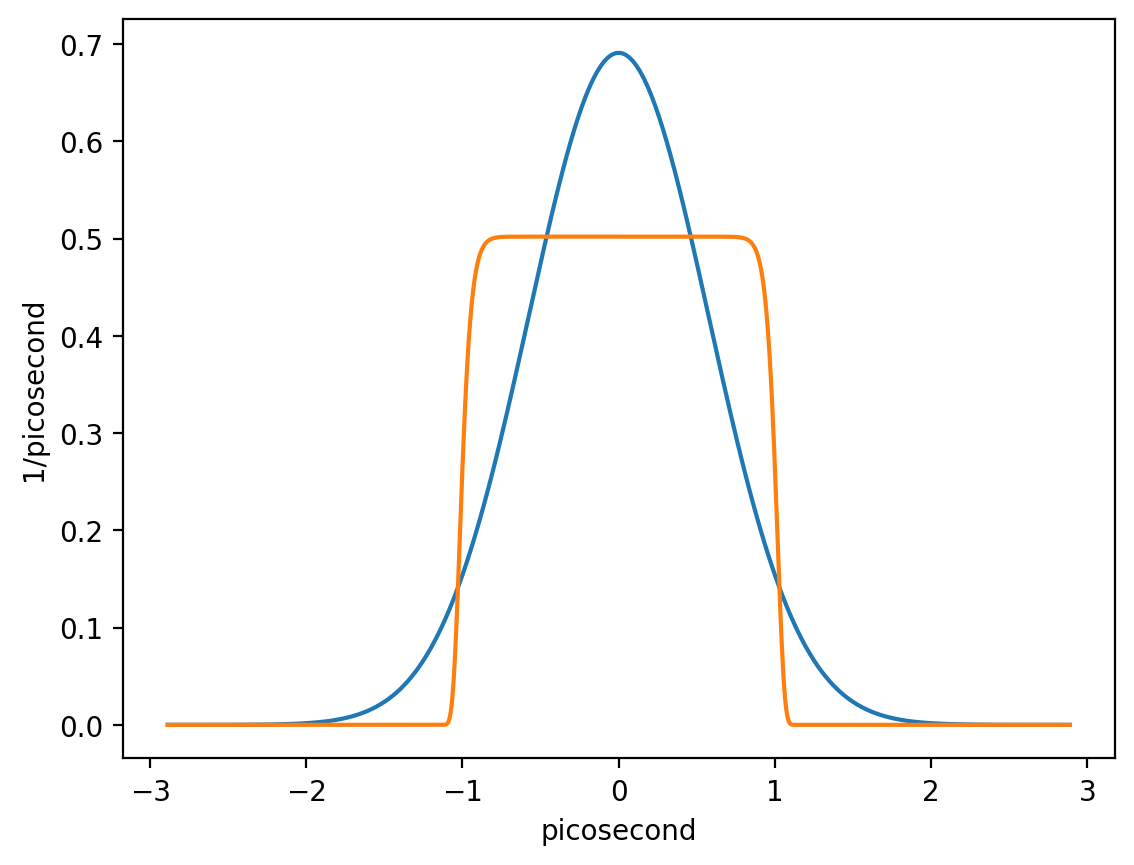

In [15]:
resample_pq(tn, Pn, tsg, Psg, plot=True);

In [16]:
dist_yaml = """
n_particle: 30000
species: electron
r_dist:
  truncation_fraction:
    units: dimensionless
    value: 0.5
  truncation_radius:
    units: mm
    value: 2.3319043122
  type: rg
random:
  type: hammersley
start:
  MTE:
    units: meV
    value: 130
  type: cathode
t_dist:
  p:
    units: ''
    value: 1
  sigma_t:
    units: ps
    value: 10
  type: sg
total_charge:
  units: pC
  value: 100
"""

In [17]:
from distgen import Generator

In [18]:
D = Generator(dist_yaml)

In [19]:
P = D.run()

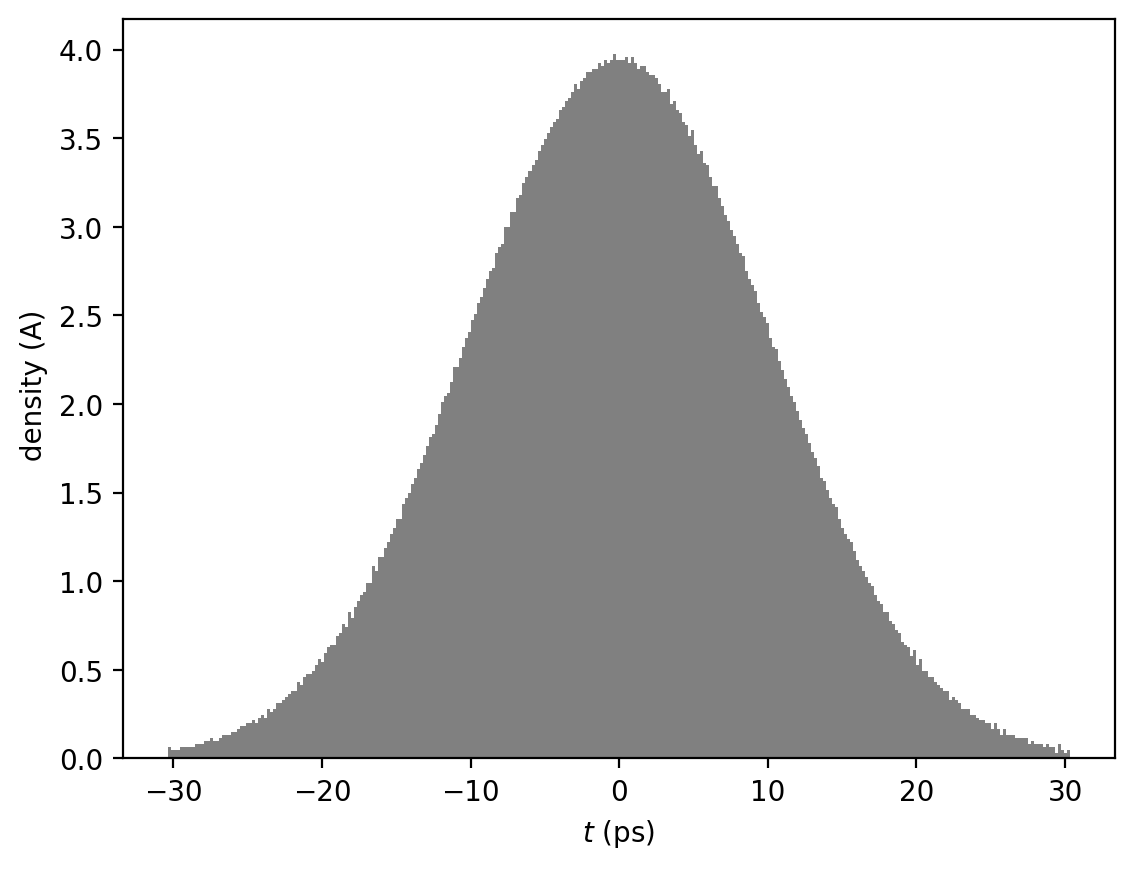

In [20]:
P.plot("t")

In [21]:
from distgen.metrics import get_current_profile
from distgen.metrics import rms_equivalent_current_nonuniformity

In [22]:
t, current_profile = get_current_profile(P)

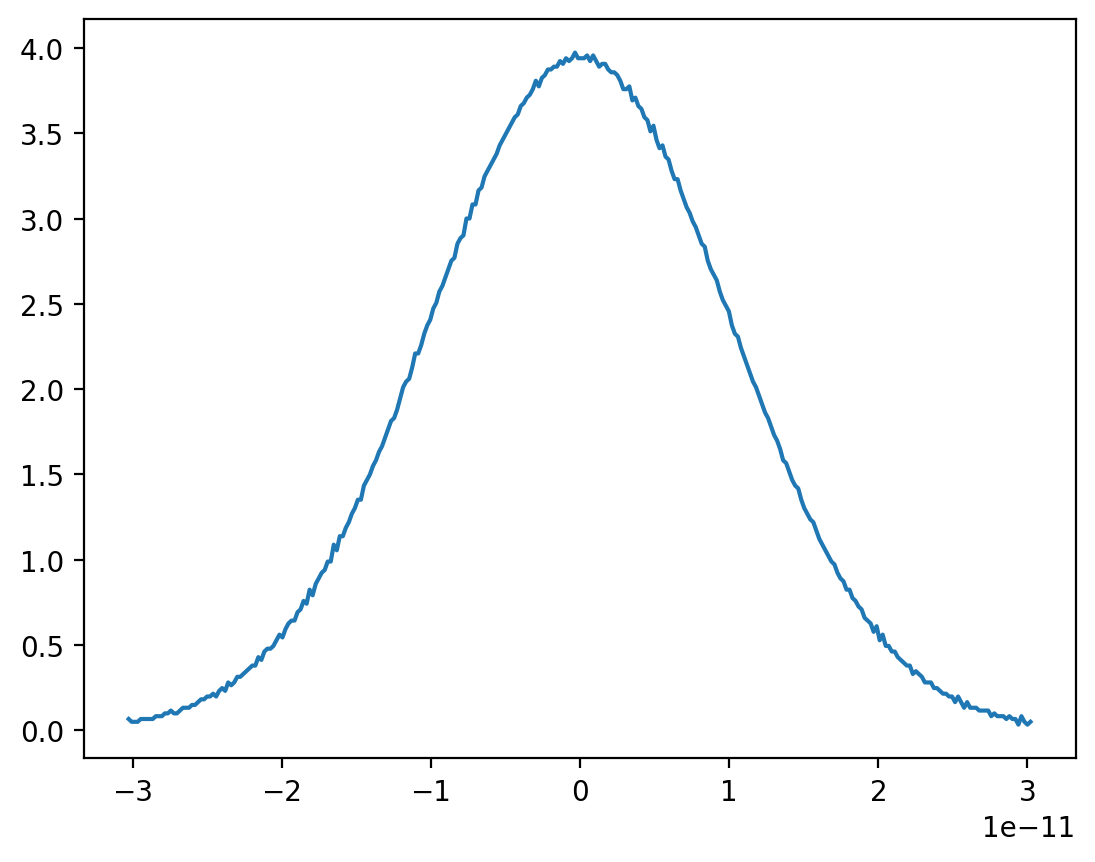

In [23]:
plt.plot(t, current_profile);

In [24]:
ps = np.linspace(1, 12, 50)

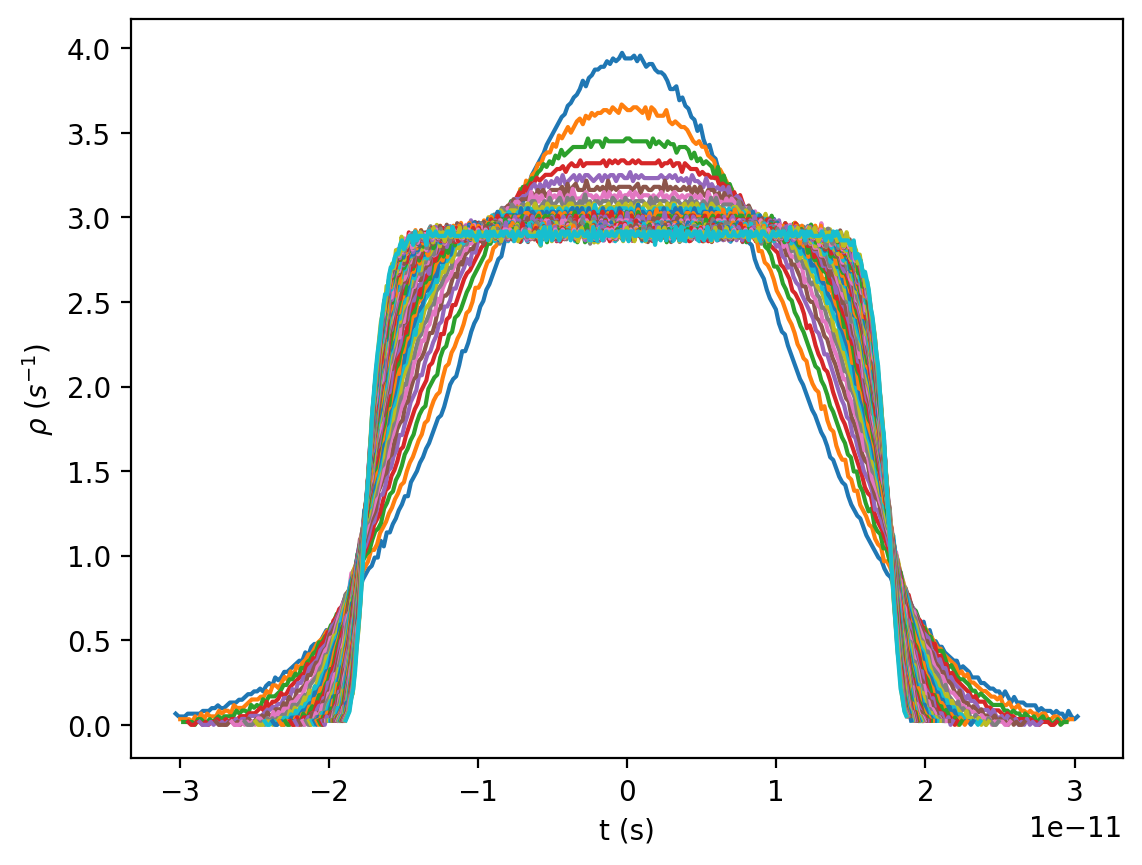

In [25]:
kldivs = np.zeros(ps.shape)
res2s = np.zeros(ps.shape)

for ii, p in enumerate(ps):
    D["t_dist:p"] = p

    P = D.run()

    t, current_profile = get_current_profile(P)

    plt.plot(t, current_profile)

    kldivs[ii] = rms_equivalent_current_nonuniformity(P, method="kl_div", p=12)

    res2s[ii] = rms_equivalent_current_nonuniformity(P, method="res2")

plt.xlabel("t (s)")
plt.ylabel("$\\rho$ ($s^{-1}$)");

$D_{KL} = \int_{-\infty}^{\infty} P\ln(P/Q)dt$

Note, not defined for uniform beam where $Q_u = \frac{1}{t_2-t_1}\left[\theta(t-t_1)-\theta(t-t_2)\right]$.  If comparing to uniform beam, replace target distribution with rms equivalent super-Gaussian with power $p$: $Q=Q_{SG}(t; p)$.  So KL-div nonuniformity:

$\lim_{p\rightarrow\infty}\int_{-\infty}^{\infty} P\ln[P/Q_{SG}(t;p)]dt$

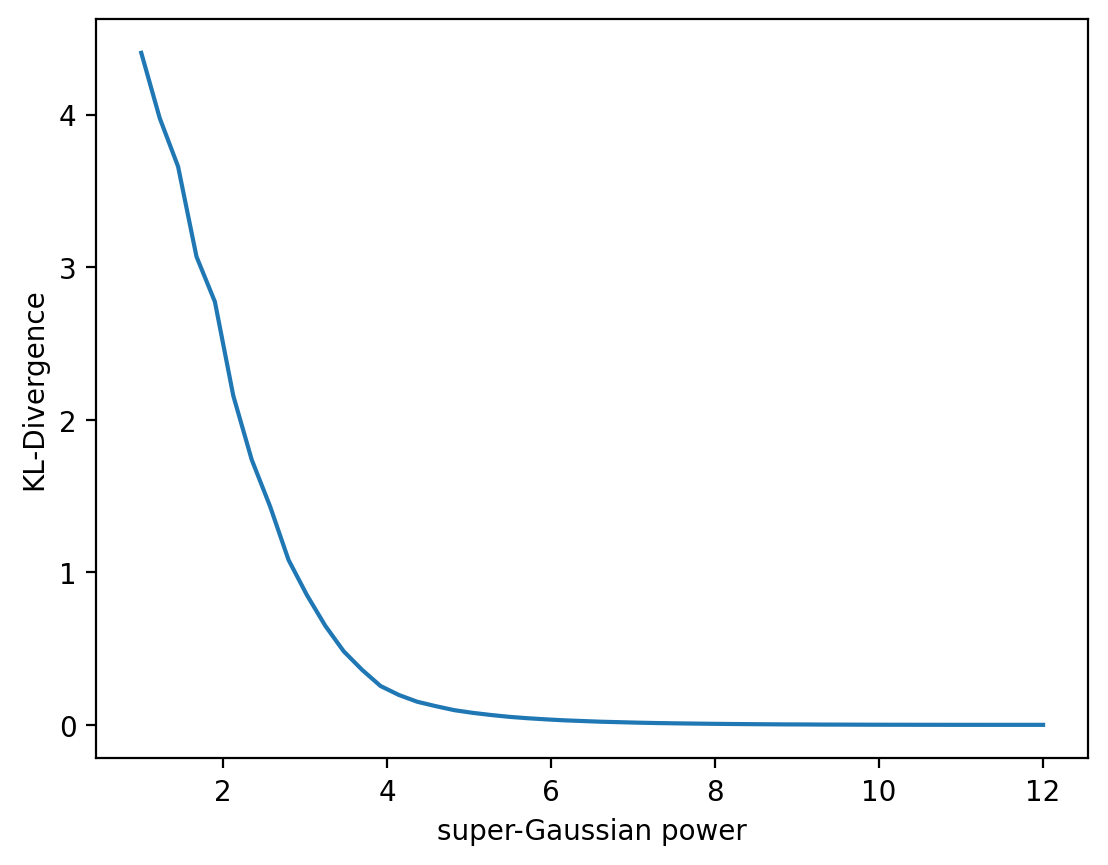

In [26]:
plt.plot(ps, kldivs)
plt.xlabel("super-Gaussian power")
plt.ylabel("KL-Divergence");

$\frac{\int_{-\infty}^{\infty} (P-Q)^2dt}{\int_{-\infty}^{\infty} Q^2(t)dt}$

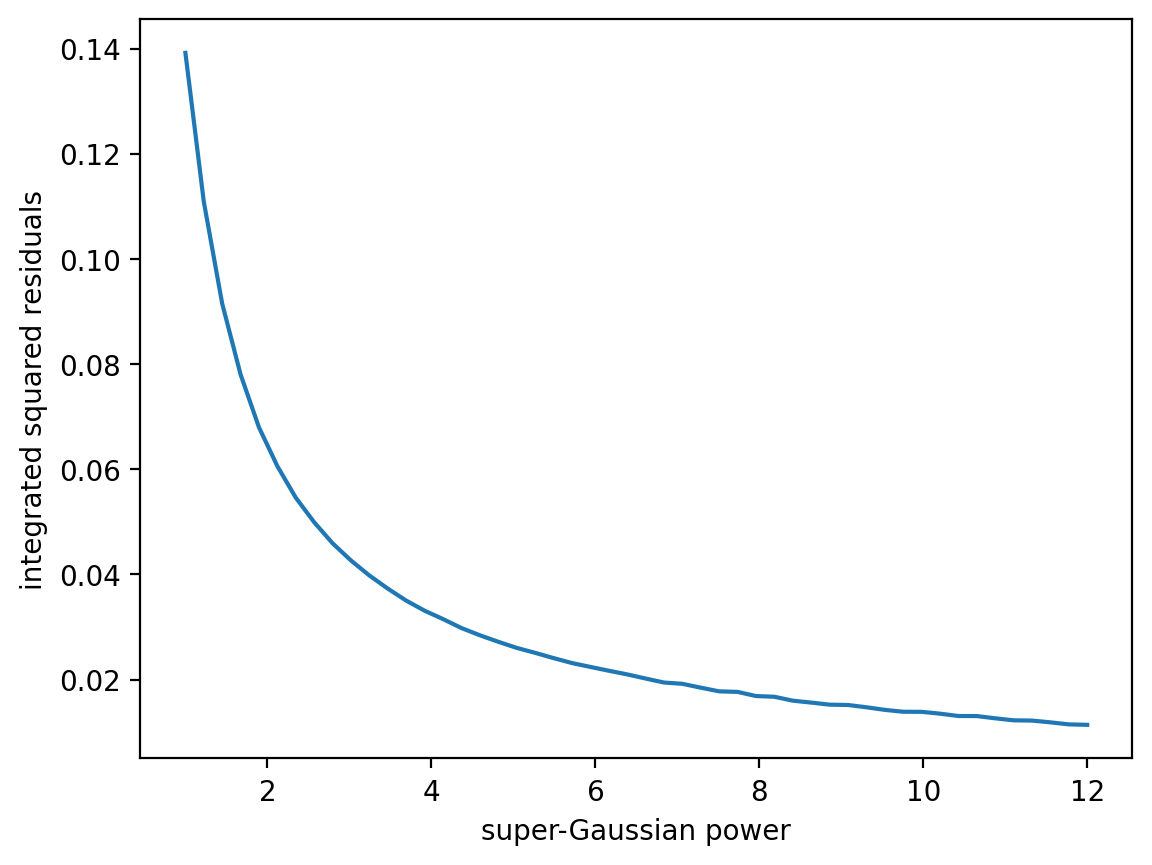

In [27]:
plt.plot(ps, res2s)
plt.xlabel("super-Gaussian power")
plt.ylabel("integrated squared residuals");

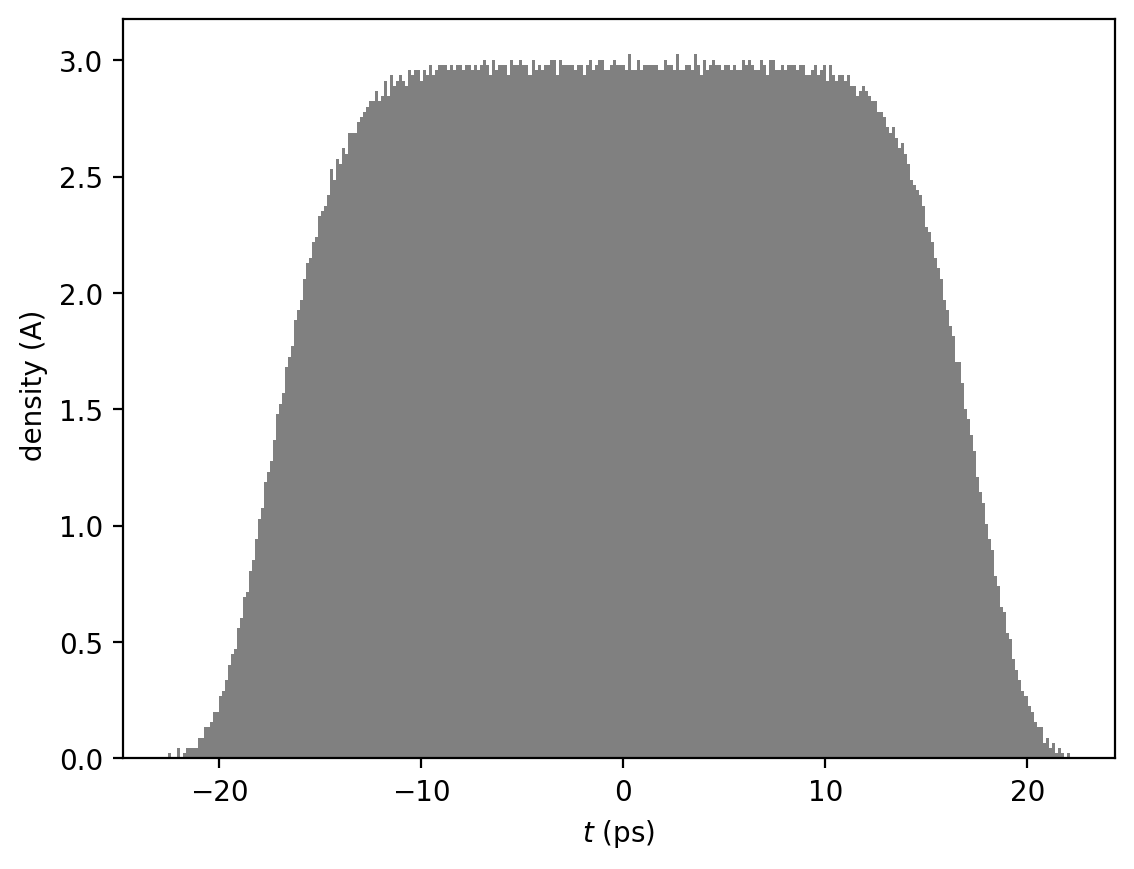

In [28]:
D["t_dist:p"] = 4
P = D.run()
P.plot("t")

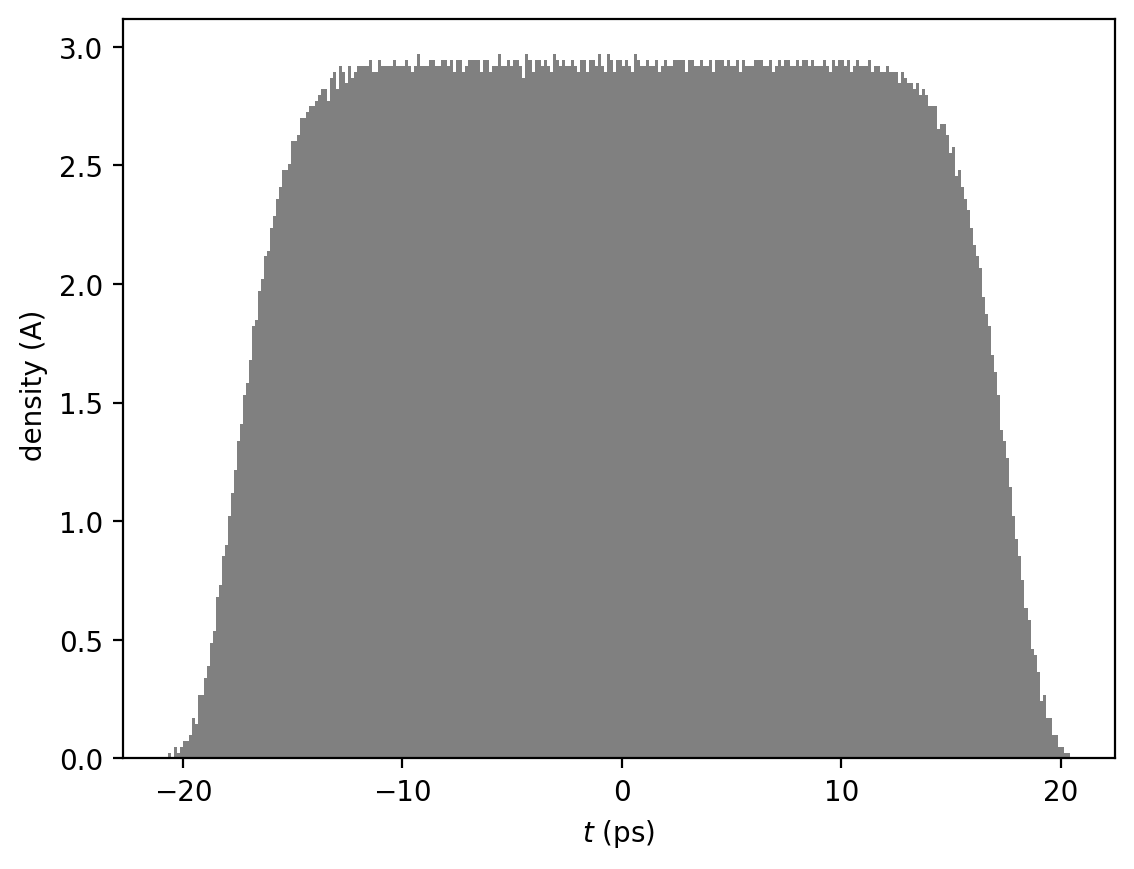

In [29]:
D["t_dist:p"] = 6
P = D.run()
P.plot("t")